In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

[LAPTOP-TL1238BG:01090] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.LAPTOP-TL1238BG.1000/jf.0/1048182784/shared_mem_cuda_pool.LAPTOP-TL1238BG could be created.
[LAPTOP-TL1238BG:01090] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


2025-06-10 13:27:08,540 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+01/s


Text(0.5, 1.0, 'Eigenvalues of Linearized Rayleigh-Bénard Convection')

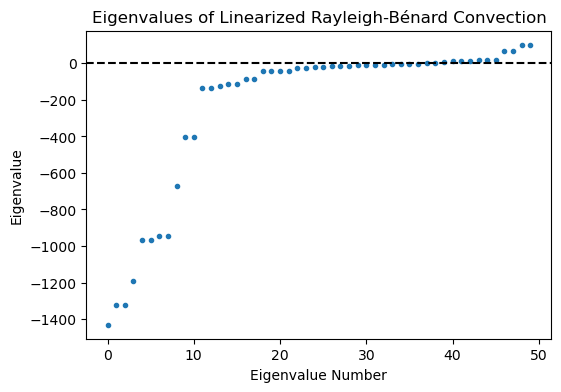

In [11]:
'''
Code solving the equation:
    (D²-k²)²ϕ = λ(D²-k²)ϕ
With the boundary conditions of y∈[0,1] with Dirichlet BCs
'''
#Variables
k = 3.14 #Wavenumber

#Setting up basis
ycoords = d3.Coordinate('y')
dist = d3.Distributor(ycoords, dtype=np.float64)
basis = d3.Chebyshev(ycoords, 64, bounds=(0,1), dealias=3/2)

#Setting up field
phi = dist.Field(name='phi', bases=basis)
tau1 = dist.Field(name='tau1')
tau2 = dist.Field(name='tau2')
lam = dist.Field(name='lam')

#Creating substitutions
y = dist.local_grid(basis)
dy = lambda A: d3.Differentiate(A, ycoords)
lift_basis = basis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

#These are here to make writing the problem simpler
phiy = dy(phi)
phiy2 = dy(phiy)
phiy3 = dy(phiy2)
phiy4 = dy(phiy3)

#Setting up problem
problem = d3.EVP([phi, tau1, tau2], eigenvalue=lam, namespace=locals())
problem.add_equation("phiy4 - 2*(k**2)*phiy2 + (k**4)*phi - lam*(phiy2 - (k**2)*phi) + lift(tau1) + lift(tau2) = 0")
problem.add_equation("phi(y=0) = 0")
problem.add_equation("phi(y=1) = 0")

#Build Solver
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
sol = np.sort(solver.eigenvalues) #Sorts the solutions into ascending order
n = np.arange(sol.size)

#Plot Solutions
plt.figure(figsize=(6,4))
plt.plot(n[0:50], sol[0:50], '.')
plt.axhline(y=0, color='black', linestyle="--")
plt.xlabel("Eigenvalue Number")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of Linearized Rayleigh-Bénard Convection")